In [1]:
%autosave 5

Autosaving every 5 seconds


## test script


Seattle Fremont Bridge bike count data

Here again, is how we downloaded the bike data, but using a jupyter notebook instead of a python script executed by bash script in the Unix shell.

    Either re-download here, or edit path to where you saved it yesterday

Download data from here: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

Right click on 'CSV' and copy link location


In [2]:
# Version 2: Downloading the data
# In this function, we write a function with conditional statements
# to decide whether the file exists or not before downloading the data
# We'll also add dataframe formatting to the function, so that the returned data
# is ready to be analyzed
import os
from urllib.request import urlretrieve
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

def get_fremont_data(filename = 'Fremont.csv', url=URL, force_download=False):
    if force_download or not os.path.exists(filename):
        # You can now download the data from the database
        urlretrieve(URL, 'Fremont.csv')
    data = pd.read_csv('Fremont.csv', index_col='Date', parse_dates=True)
    data.columns = ['East', 'West']
    data['Total'] = data['West'] + data['East']
    return data

In [3]:
data = get_fremont_data()
data.head()

,East,West,Total
Date,,,
2012-10-03 00:00:00,9.0,4.0,13.0
2012-10-03 01:00:00,6.0,4.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,3.0,2.0,5.0
2012-10-03 04:00:00,1.0,6.0,7.0


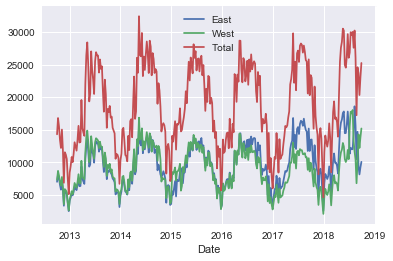

In [4]:
data.resample('W').sum().plot()

(0, 1080850.45)

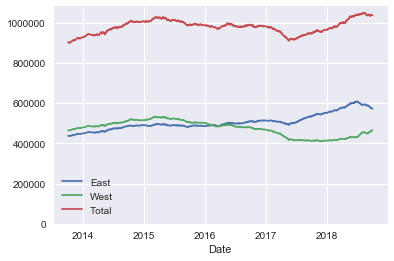

In [5]:
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

(0, 1080850.45)

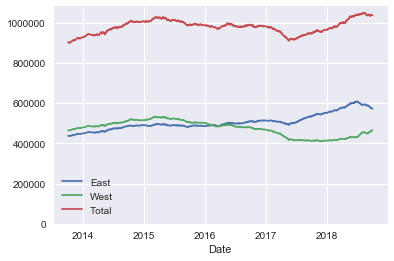

In [6]:
data['Total'] = data['West'] + data['East']
ax = data.resample('D').sum().rolling(365).sum().plot()
ax.set_ylim(0, None)

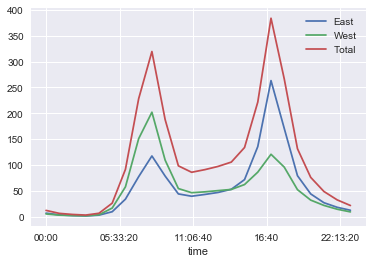

In [7]:
data.groupby(data.index.time).mean().plot()

In [8]:
pivoted = data.pivot_table('East', index = data.index.time, columns = data.index.date)
pivoted.iloc[:5, :5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,9.0,11.0,7.0,7.0,5.0
01:00:00,6.0,0.0,4.0,5.0,5.0
02:00:00,1.0,6.0,3.0,2.0,1.0
03:00:00,3.0,3.0,2.0,2.0,2.0
04:00:00,1.0,1.0,2.0,1.0,2.0


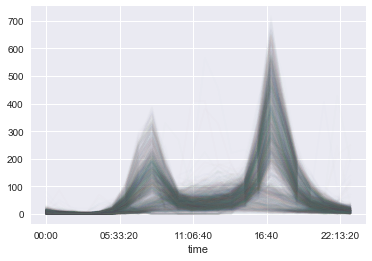

In [9]:
pivoted.plot(legend=False, alpha=0.01)